In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import os

In [2]:
from PIL import Image
import pandas as pd

In [352]:
train_filenames = os.listdir("datasets/HSE/train_cells")
classes = pd.read_csv("datasets/HSE/train_classes.csv", index_col="image")
j = 0

x = [[], [], [], []]

class0_line = ""
class1_line = ""
class2_line = ""
class3_line = ""

for i in range(len(train_filenames)):
    if train_filenames[i].startswith("."):
        continue
        
    train_image = Image.open("datasets/HSE/train_cells/" + train_filenames[i])
    pixels_line = (np.asarray(train_image).flatten() / 255).astype(np.float32)
    class_name = classes.loc[os.path.splitext(train_filenames[i])[0]]['class'].astype(np.uint8)
    
    if class_name == 1:
        class_name = 0 # А
        x[class_name].append(pixels_line)
        class0_line += train_filenames[i] + ","
    elif class_name == 29:
        class_name = 1 # ь
        x[class_name].append(pixels_line)
        class1_line += train_filenames[i] + ","
#         x_class1[count_class1] = pixels_line
#         y_class1[count_class1] = class_name
#         count_class1 += 1
    elif class_name == 15:
        class_name = 2 # o
        x[class_name].append(pixels_line)
        class2_line += train_filenames[i] + ","
    elif class_name == 19:
        class_name = 3 # т
        x[class_name].append(pixels_line)
        class3_line += train_filenames[i] + ","
    else:
        continue
        
print(len(x[0]), len(x[1]), len(x[2]), len(x[3]))
print(class0_line, "\n")
print(class1_line, "\n")
print(class2_line, "\n")
print(class3_line, "\n")

55 53 55 57
cell2392.jpg,cell0630.jpg,cell1512.jpg,cell0593.jpg,cell0949.jpg,cell2408.jpg,cell0431.jpg,cell1703.jpg,cell3317.jpg,cell1258.jpg,cell1112.jpg,cell3275.jpg,cell0973.jpg,cell0755.jpg,cell1885.jpg,cell2977.jpg,cell2938.jpg,cell0519.jpg,cell1836.jpg,cell2126.jpg,cell2867.jpg,cell0081.jpg,cell3371.jpg,cell1748.jpg,cell2693.jpg,cell0251.jpg,cell3189.jpg,cell1211.jpg,cell0455.jpg,cell1950.jpg,cell1818.jpg,cell2310.jpg,cell2502.jpg,cell3368.jpg,cell2103.jpg,cell0660.jpg,cell1780.jpg,cell0111.jpg,cell0374.jpg,cell2359.jpg,cell3245.jpg,cell0598.jpg,cell1123.jpg,cell2560.jpg,cell1096.jpg,cell2987.jpg,cell2405.jpg,cell0548.jpg,cell1496.jpg,cell1737.jpg,cell1537.jpg,cell3320.jpg,cell1286.jpg,cell1443.jpg,cell0006.jpg, 

cell2973.jpg,cell2797.jpg,cell1894.jpg,cell1935.jpg,cell2226.jpg,cell2540.jpg,cell0627.jpg,cell2424.jpg,cell0387.jpg,cell2291.jpg,cell2087.jpg,cell0645.jpg,cell1942.jpg,cell2696.jpg,cell1770.jpg,cell0650.jpg,cell2255.jpg,cell0318.jpg,cell0657.jpg,cell3389.jpg,cell2849.j

In [353]:
train_percentage = 0.8

x_train = []
x_test = []
y_train = []
y_test = []
for i in range(4):
    x_train += x[i][:round(len(x[i]) * train_percentage)]
    x_test += x[i][round(len(x[i]) * train_percentage):]
    
    for j in range(round(len(x[i]) * train_percentage)):
        y_train.append(i)

    for k in range(len(x[i]) - round(len(x[i]) * train_percentage)):
        y_test.append(i)

print(len(x_train), len(x_test), len(y_train), len(y_test))

176 44 176 44


In [354]:
for old_index in range(len(x_train)):
    new_index = np.random.randint(old_index+1)
    x_train[old_index], x_train[new_index] = x_train[new_index], x_train[old_index]
    y_train[old_index], y_train[new_index] = y_train[new_index], y_train[old_index]
    
for old_index in range(len(x_test)):
    new_index = np.random.randint(old_index+1)
    x_test[old_index], x_test[new_index] = x_test[new_index], x_test[old_index]
    y_test[old_index], y_test[new_index] = y_test[new_index], y_test[old_index]

print(len(x_train), len(x_test), len(y_train), len(y_test))

176 44 176 44


In [355]:
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array([[1 if i == y_train[j] else 0 for i in range(4)] for j in range(len(y_train))])
y_test = np.array([[1 if i == y_test[j] else 0 for i in range(4)] for j in range(len(y_test))])

In [356]:
def sigmoid(x, derivative = False):
    if derivative:
        return np.exp(-x) / ((np.exp(-x) + 1) ** 2)
    else:
        return 1 / (1 + np.exp(-x))

In [357]:
def nn_init(lsize):
    input_layer  = lsize[0]
    hidden_1     = lsize[1]
    hidden_2     = lsize[2]
    output_layer = lsize[3]
    
    # narrowing down the standard deviation by layer size, with np.sqrt()
    # large layers have tighter initial values
    nnet = {
        'w0': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
        'w1': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
        'w2': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
    }
    return nnet

In [358]:
def softmax(x, derivative = False):
    # for stability, we shift values down so max = 0
    # https://cs231n.github.io/linear-classify/#softmax
    exp_shifted = np.exp(x - x.max())
    if derivative:
        return exp_shifted / np.sum(exp_shifted, axis = 0) * (1 - exp_shifted / np.sum(exp_shifted, axis = 0))
    else:
        return exp_shifted / np.sum(exp_shifted, axis = 0)

In [359]:
def forward_pass(x):
    # the model is a global var, used here read-only
    
    # NN state: internal sums, neuron outputs
    nn_state = {}
    
    # "output zero" is the output from receptors = input to first layer in the NN
    # these are activations for the input layer
    nn_state['o0'] = x
    
    # from input layer to hidden layer 1
    # weighted sum of all activations, then sigmoid
    nn_state['z1'] = np.dot(model['w0'], nn_state['o0'])
    nn_state['o1'] = sigmoid(nn_state['z1'])
    
    # from hidden 1 to hidden 2
    nn_state['z2'] = np.dot(model['w1'], nn_state['o1'])
    nn_state['o2'] = sigmoid(nn_state['z2'])
    
    # from hidden 2 to output
    nn_state['z3'] = np.dot(model['w2'], nn_state['o2'])
    nn_state['o3'] = softmax(nn_state['z3'])
    
    return nn_state

In [360]:
def part_cost(o, y):
    cost = 0
    for i in range(len(y)):
        cost += y[i]*np.log(o[i])+(1-y[i])*np.log(1-o[i])
    
#     c = np.dot(y, np.log(o)) + np.dot((1 - y), np.log(1 - o))
    return -cost

In [361]:
def backward_pass(x, y):
    # do the forward pass, register the state of the network
    nn_state = forward_pass(x)
    
    # small deltas: derivatives of the error w.r.t. z
    nn_state['d3'] = nn_state['o3'] - y
    nn_state['d2'] = np.dot(nn_state['d3'], model['w2']) * softmax(nn_state['z2'], derivative = True)
    nn_state['d1'] = np.dot(nn_state['d2'], model['w1']) * sigmoid(nn_state['z1'], derivative = True)
    
    # large deltas: adjustments to weights
    nn_state['D2'] = np.outer(nn_state['d3'], nn_state['o2'])
    nn_state['D1'] = np.outer(nn_state['d2'], nn_state['o1'])
    nn_state['D0'] = np.outer(nn_state['d1'], nn_state['o0'])
    
    return nn_state

In [362]:
layer_sizes = [2112, 256, 128, 4]
model = nn_init(layer_sizes)

In [363]:
epochs = 1000

t_rate = 0.01
# t_rate_decrease = 0.7
t_rate_decrease = 1
# t_rate_increase = 1.05
t_rate_increase = 1
error_increase_lim = 1.04
prev_cost = 0

costs = []
accuracies = []
t_rates = []

print('################### training ####################')
# for e in tqdm(range(epochs)):
while accuracy <= 0.98 and len(costs) <= epochs:
#     print('epoch:', e)
    
    samples = x_train.shape[0]
    cost = 0
    hit_count = 0
    
    for i in range(samples):
#         print(x_train[i])
        m_state = backward_pass(x_train[i], y_train[i])
        # add partial cost
#         print(m_state['o3'], y_train[i])
        cost += part_cost(m_state['o3'], y_train[i])
#         print(cost)
        
        # stochastic gradient descent update weights
        model['w0'] -= t_rate * m_state['D0']
        model['w1'] -= t_rate * m_state['D1']
        model['w2'] -= t_rate * m_state['D2']
        
        if np.argmax(m_state['o3']) == np.argmax(y_train[i]):
            hit_count += 1

    #update t_rate
#     if cost > error_increase_lim * prev_cost:
#         t_rate *= t_rate_decrease
#     else:
#         t_rate *= t_rate_increase
    
#     prev_cost = cost
    
    # performance evaluation
    cost = cost / samples
    accuracy = hit_count / samples
    costs.append(cost)
    accuracies.append(accuracy)
    t_rates.append(t_rate)
    print('cost:', cost, 'accuracy:', accuracy, 'e:', len(costs))

total_cost = cost
total_accuracy = accuracy
print(total_cost, total_accuracy)

# save the model
with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)

################### training ####################
cost: 2.4510136267665157 accuracy: 0.2159090909090909 e: 1
cost: 2.4046510257093927 accuracy: 0.23863636363636365 e: 2
cost: 2.3832528581814483 accuracy: 0.25 e: 3
cost: 2.3625006317119475 accuracy: 0.26136363636363635 e: 4
cost: 2.3426447598573277 accuracy: 0.2727272727272727 e: 5
cost: 2.3239394191107015 accuracy: 0.2784090909090909 e: 6
cost: 2.306548526620223 accuracy: 0.2840909090909091 e: 7
cost: 2.290502680708151 accuracy: 0.29545454545454547 e: 8
cost: 2.2756486712405364 accuracy: 0.30113636363636365 e: 9
cost: 2.2616096668980243 accuracy: 0.32386363636363635 e: 10
cost: 2.24796868256295 accuracy: 0.3352272727272727 e: 11
cost: 2.2344488223612675 accuracy: 0.3352272727272727 e: 12
cost: 2.221099649407315 accuracy: 0.3409090909090909 e: 13
cost: 2.2083690427435108 accuracy: 0.35795454545454547 e: 14
cost: 2.196138910851388 accuracy: 0.35795454545454547 e: 15
cost: 2.1835905635969444 accuracy: 0.36363636363636365 e: 16
cost: 2.170

cost: 1.7110270591252765 accuracy: 0.6136363636363636 e: 139
cost: 1.7051490412997163 accuracy: 0.6136363636363636 e: 140
cost: 1.6992914748151464 accuracy: 0.6136363636363636 e: 141
cost: 1.6934582983755384 accuracy: 0.6136363636363636 e: 142
cost: 1.687659285950801 accuracy: 0.6136363636363636 e: 143
cost: 1.6819084624795175 accuracy: 0.625 e: 144
cost: 1.6762209669910002 accuracy: 0.6306818181818182 e: 145
cost: 1.670609543973437 accuracy: 0.6306818181818182 e: 146
cost: 1.6650815242203736 accuracy: 0.6306818181818182 e: 147
cost: 1.6596366202249775 accuracy: 0.6363636363636364 e: 148
cost: 1.654265445394084 accuracy: 0.6363636363636364 e: 149
cost: 1.648948474168291 accuracy: 0.6363636363636364 e: 150
cost: 1.6436551848138559 accuracy: 0.6363636363636364 e: 151
cost: 1.638343394375812 accuracy: 0.6363636363636364 e: 152
cost: 1.6329594372377152 accuracy: 0.6363636363636364 e: 153
cost: 1.6274410224774387 accuracy: 0.6420454545454546 e: 154
cost: 1.6217258584181338 accuracy: 0.64204

cost: 1.325308422742731 accuracy: 0.6647727272727273 e: 274
cost: 1.3234911533981375 accuracy: 0.6647727272727273 e: 275
cost: 1.3216772980272657 accuracy: 0.6647727272727273 e: 276
cost: 1.3198666921141344 accuracy: 0.6647727272727273 e: 277
cost: 1.3180591592179138 accuracy: 0.6647727272727273 e: 278
cost: 1.3162545100931362 accuracy: 0.6647727272727273 e: 279
cost: 1.3144525417167612 accuracy: 0.6647727272727273 e: 280
cost: 1.312653036212836 accuracy: 0.6647727272727273 e: 281
cost: 1.3108557596654307 accuracy: 0.6647727272727273 e: 282
cost: 1.3090604608100926 accuracy: 0.6647727272727273 e: 283
cost: 1.3072668695943384 accuracy: 0.6647727272727273 e: 284
cost: 1.3054746955983214 accuracy: 0.6647727272727273 e: 285
cost: 1.3036836263077307 accuracy: 0.6647727272727273 e: 286
cost: 1.301893325233265 accuracy: 0.6647727272727273 e: 287
cost: 1.3001034298737015 accuracy: 0.6647727272727273 e: 288
cost: 1.2983135495242624 accuracy: 0.6647727272727273 e: 289
cost: 1.2965232629378631 ac

cost: 1.1365157800891348 accuracy: 0.6931818181818182 e: 411
cost: 1.1355999534031012 accuracy: 0.6931818181818182 e: 412
cost: 1.1346873552936048 accuracy: 0.6931818181818182 e: 413
cost: 1.1337779975171227 accuracy: 0.6931818181818182 e: 414
cost: 1.1328718912893554 accuracy: 0.6931818181818182 e: 415
cost: 1.131969047339494 accuracy: 0.6931818181818182 e: 416
cost: 1.1310694759664268 accuracy: 0.6931818181818182 e: 417
cost: 1.1301731870971812 accuracy: 0.6931818181818182 e: 418
cost: 1.1292801903476288 accuracy: 0.6931818181818182 e: 419
cost: 1.128390495085859 accuracy: 0.6931818181818182 e: 420
cost: 1.1275041104984345 accuracy: 0.6931818181818182 e: 421
cost: 1.1266210456598993 accuracy: 0.6931818181818182 e: 422
cost: 1.125741309606065 accuracy: 0.6931818181818182 e: 423
cost: 1.1248649114113372 accuracy: 0.6931818181818182 e: 424
cost: 1.1239918602709424 accuracy: 0.6931818181818182 e: 425
cost: 1.1231221655884533 accuracy: 0.6931818181818182 e: 426
cost: 1.1222558370695122 ac

cost: 1.0376306037025147 accuracy: 0.6988636363636364 e: 546
cost: 1.0370564532581432 accuracy: 0.6988636363636364 e: 547
cost: 1.0364810367841146 accuracy: 0.7045454545454546 e: 548
cost: 1.0359033311372399 accuracy: 0.7045454545454546 e: 549
cost: 1.0353222579390096 accuracy: 0.7045454545454546 e: 550
cost: 1.0347367631845612 accuracy: 0.7045454545454546 e: 551
cost: 1.0341459062568685 accuracy: 0.7045454545454546 e: 552
cost: 1.0335489422397868 accuracy: 0.7045454545454546 e: 553
cost: 1.0329453821194574 accuracy: 0.7045454545454546 e: 554
cost: 1.032335021258273 accuracy: 0.7045454545454546 e: 555
cost: 1.0317179349463732 accuracy: 0.7045454545454546 e: 556
cost: 1.031094447384483 accuracy: 0.7045454545454546 e: 557
cost: 1.0304650845830432 accuracy: 0.7045454545454546 e: 558
cost: 1.0298305218373593 accuracy: 0.7045454545454546 e: 559
cost: 1.0291915338116469 accuracy: 0.7045454545454546 e: 560
cost: 1.0285489516152515 accuracy: 0.7045454545454546 e: 561
cost: 1.0279036280285598 a

cost: 0.9877994065282134 accuracy: 0.7045454545454546 e: 681
cost: 0.9877380286423278 accuracy: 0.7045454545454546 e: 682
cost: 0.987666318012128 accuracy: 0.7045454545454546 e: 683
cost: 0.9875850324046472 accuracy: 0.7045454545454546 e: 684
cost: 0.9874951478485013 accuracy: 0.7045454545454546 e: 685
cost: 0.9873978042001017 accuracy: 0.7045454545454546 e: 686
cost: 0.9872942428727574 accuracy: 0.7102272727272727 e: 687
cost: 0.9871857406305053 accuracy: 0.7102272727272727 e: 688
cost: 0.9870735431811692 accuracy: 0.7102272727272727 e: 689
cost: 0.9869588020437381 accuracy: 0.7102272727272727 e: 690
cost: 0.986842517868741 accuracy: 0.7102272727272727 e: 691
cost: 0.9867254930306455 accuracy: 0.7102272727272727 e: 692
cost: 0.9866082958197595 accuracy: 0.7102272727272727 e: 693
cost: 0.9864912378913175 accuracy: 0.7102272727272727 e: 694
cost: 0.9863743658118911 accuracy: 0.7102272727272727 e: 695
cost: 0.9862574667042968 accuracy: 0.7102272727272727 e: 696
cost: 0.9861400873262478 a

cost: 0.9278679577419907 accuracy: 0.7613636363636364 e: 821
cost: 0.9272080905421525 accuracy: 0.7613636363636364 e: 822
cost: 0.9265522680602447 accuracy: 0.7613636363636364 e: 823
cost: 0.9259005016623444 accuracy: 0.7613636363636364 e: 824
cost: 0.9252527978147392 accuracy: 0.7613636363636364 e: 825
cost: 0.9246091585127325 accuracy: 0.7613636363636364 e: 826
cost: 0.923969581703718 accuracy: 0.7670454545454546 e: 827
cost: 0.9233340617009037 accuracy: 0.7670454545454546 e: 828
cost: 0.9227025895837432 accuracy: 0.7670454545454546 e: 829
cost: 0.9220751535808165 accuracy: 0.7670454545454546 e: 830
cost: 0.9214517394314673 accuracy: 0.7670454545454546 e: 831
cost: 0.9208323307228782 accuracy: 0.7727272727272727 e: 832
cost: 0.9202169092000144 accuracy: 0.7727272727272727 e: 833
cost: 0.9196054550468212 accuracy: 0.7727272727272727 e: 834
cost: 0.9189979471377374 accuracy: 0.7727272727272727 e: 835
cost: 0.9183943632594506 accuracy: 0.7727272727272727 e: 836
cost: 0.917794680303556 a

cost: 0.864671852186748 accuracy: 0.8181818181818182 e: 965
cost: 0.8643994688967187 accuracy: 0.8181818181818182 e: 966
cost: 0.8641290305141809 accuracy: 0.8181818181818182 e: 967
cost: 0.8638605313822023 accuracy: 0.8181818181818182 e: 968
cost: 0.8635939656791617 accuracy: 0.8181818181818182 e: 969
cost: 0.8633293274220122 accuracy: 0.8181818181818182 e: 970
cost: 0.8630666104695504 accuracy: 0.8238636363636364 e: 971
cost: 0.8628058085255148 accuracy: 0.8238636363636364 e: 972
cost: 0.86254691514157 accuracy: 0.8238636363636364 e: 973
cost: 0.8622899237200993 accuracy: 0.8238636363636364 e: 974
cost: 0.8620348275168443 accuracy: 0.8238636363636364 e: 975
cost: 0.861781619643348 accuracy: 0.8238636363636364 e: 976
cost: 0.8615302930691834 accuracy: 0.8238636363636364 e: 977
cost: 0.8612808406239693 accuracy: 0.8238636363636364 e: 978
cost: 0.8610332549991966 accuracy: 0.8238636363636364 e: 979
cost: 0.860787528749885 accuracy: 0.8238636363636364 e: 980
cost: 0.8605436542959801 accu

<function matplotlib.pyplot.show(close=None, block=None)>

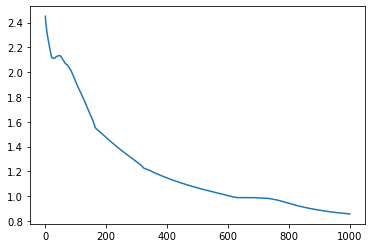

In [364]:
# plt.plot(np.arange(epochs), np.array(costs))
plt.plot(np.arange(len(costs)), np.array(costs))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

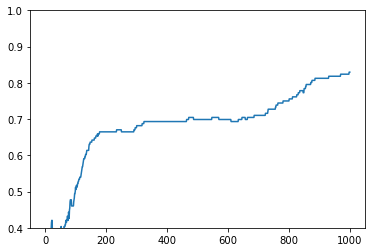

In [365]:
plt.plot(np.arange(len(accuracies)), np.array(accuracies))
axis = plt.gca()
axis.set_ylim([0.4, 1.])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

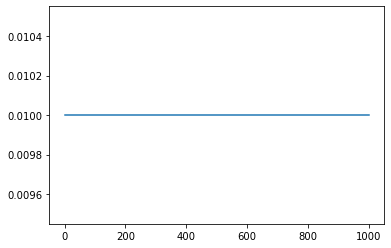

In [366]:
plt.plot(np.arange(len(t_rates)), np.array(t_rates))
axis = plt.gca()
plt.show

In [367]:
# test
print('################### testing ####################')
# load the model
if os.path.isfile('model.pickle'):
    with open('model.pickle', 'rb') as f:
        model = pickle.load(f)

# run the whole test data
samples = x_test.shape[0]
costs = [0, 0, 0, 0]
hit_counts = [0, 0, 0, 0]

cost = 0
hit_count = 0

for i in tqdm(range(samples)):
    m_state = forward_pass(x_test[i])
    
    p_cost = part_cost(m_state['o3'], y_test[i])
    costs[np.argmax(y_test[i])] += p_cost
    cost += p_cost
    
    if np.argmax(m_state['o3']) == np.argmax(y_test[i]):
        hit_count += 1
        hit_counts[np.argmax(y_test[i])] += 1

# evaluate performance
cost = cost / samples
accuracy = float(hit_count) / float(samples)
print('Total cost:', cost, 'Total accuracy:', accuracy)

print('Class 0 cost:', costs[0] / (len(x[0]) * (1 - train_percentage)), 
      'Class 0 accuracy:', float(hit_counts[0]) / float(len(x[0]) * (1 - train_percentage)))
print('Class 1 cost:', costs[1] / (len(x[1]) * (1 - train_percentage)), 
      'Class 1 accuracy:', float(hit_counts[1]) / float((len(x[1]) * (1 - train_percentage))))
print('Class 2 cost:', costs[2] / (len(x[2]) * (1 - train_percentage)), 
      'Class 2 accuracy:', float(hit_counts[2]) / float((len(x[2]) * (1 - train_percentage))))
print('Class 3 cost:', costs[3] / (len(x[3]) * (1 - train_percentage)), 
      'Class 3 accuracy:', float(hit_counts[3]) / float((len(x[3]) * (1 - train_percentage))))

################### testing ####################


100%|██████████████████████████████████████████| 44/44 [00:00<00:00, 581.09it/s]

Total cost: 1.805253117383318 Total accuracy: 0.5227272727272727
Class 0 cost: 2.2840006361269696 Class 0 accuracy: 0.3636363636363637
Class 1 cost: 1.87871719189407 Class 1 accuracy: 0.6603773584905662
Class 2 cost: 1.0371677935385573 Class 2 accuracy: 0.9090909090909093
Class 3 cost: 2.016130017935794 Class 3 accuracy: 0.17543859649122812


In [314]:
def predict(image):
    if os.path.isfile('model.pickle'):
        with open('model.pickle', 'rb') as f:
            model = pickle.load(f)
    
    m_state = forward_pass(image)
    return np.argmax(m_state['o3'])

1


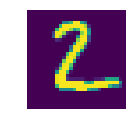

In [122]:
digit = x_test[1]

digit_pixels = digit.reshape(28, 28)
plt.subplot(131)
plt.imshow(digit_pixels)
plt.axis('off')

result = predict(digit)
print(result)

In [308]:
len(x[2])

55